In [1]:
import os
import sys
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm
from pathlib import Path
from functools import reduce
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor


plt.rcParams['font.weight'] = 'normal' 
plt.rcParams['font.size'] = 14
HOME = Path.cwd().parent
sys.path.append(str(HOME))

In [2]:
# Try to load back
with open(HOME / 'cache/transfer.pkl', 'rb') as f:
    mat2bat = pickle.load(f)

In [3]:
class ConvModule(nn.Module):
    def __init__(self, din, dout, kernel_size,
                 act_fn: str = 'relu',
                 dropout: float = 0.1):
        nn.Module.__init__(self)
        self.kernel_size = kernel_size
        self.conv1 = nn.Conv2d(din, dout, kernel_size)
        self.pool1 = nn.AvgPool2d(kernel_size)
        self.conv2 = nn.Conv2d(dout, dout, kernel_size)
        self.pool2 = nn.AvgPool2d(kernel_size)
        self.act_fn = getattr(torch, act_fn)
        self.dropout = nn.Dropout2d(dropout)

    def output_shape(self, H, W):
        # conv1 output
        H, W = H - self.kernel_size[0] + 1, W - self.kernel_size[1] + 1
        # pool1 output
        H = int((H - self.kernel_size[0]) / self.kernel_size[0] + 1)
        W = int((W - self.kernel_size[1]) / self.kernel_size[1] + 1)
        # conv2 output
        H, W = H - self.kernel_size[0] + 1, W - self.kernel_size[1] + 1
        # pool2 output
        H = int((H - self.kernel_size[0]) / self.kernel_size[0] + 1)
        W = int((W - self.kernel_size[1]) / self.kernel_size[1] + 1)

        return H, W

    def forward(self, x):
        x = self.conv1(x)
        x = self.act_fn(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act_fn(x)
        x = self.pool2(x)

        return x


class CNNRULPredictor(nn.Module):
    def __init__(self,
                 in_channels: int,
                 channels: int,
                 input_height: int,
                 input_width: int,
                 kernel_size=3,
                 act_fn: str = 'relu'):
        nn.Module.__init__(self)
        self.channels = channels
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if input_height < kernel_size[0]:
            kernel_size = (input_height, kernel_size[1])
        if input_width < kernel_size[1]:
            kernel_size = (kernel_size[0], input_width)
        self.encoder = ConvModule(in_channels, channels, kernel_size, act_fn)
        H, W = self.encoder.output_shape(input_height, input_width)
        self.proj = nn.Conv2d(channels, channels, (H, W))
        self.fc = nn.Linear(channels, 1)

    def forward(self, feature: torch.Tensor):
        x = self.encoder(feature)
        x = self.proj(x)
        x = x.view(-1, self.channels)
        x = torch.relu(x)
        x = self.fc(x).view(-1)

        return x


class Dataset:
    def __init__(self, features, labels, sup_features=None, sup_labels=None):
        self.features = features.float()
        self.labels = labels.float()
        if sup_features is not None:
            sup_features = sup_features.float()
        if sup_labels is not None:
            sup_labels = sup_labels.float()
        self.sup_features = sup_features
        self.sup_labels = sup_labels

    def is_intercd_dataset(self):
        return self.sup_features is not None and self.sup_labels is not None

    def __len__(self):
        if self.is_intercd_dataset():
            return len(self.labels) * len(self.sup_labels)
        return len(self.labels)

    def __getitem__(self, item):
        if self.is_intercd_dataset():
            i = item // len(self.sup_labels)
            j = item % len(self.sup_labels)
            feature = self.features[i] - self.sup_features[j]
            label = self.labels[i] - self.sup_labels[j]
            return feature, label
        else:
            return self.features[item], self.labels[item]

    def to(self, device):
        self.labels = self.labels.to(device)
        self.features = self.features.to(device)
        if self.is_intercd_dataset():
            self.sup_labels = self.sup_labels.to(device)
            self.sup_features = self.sup_features.to(device)
        return self


class Subset:
    def __init__(self, dataset, index):
        self.dataset = dataset
        self.index = index

    def __len__(self):
        return len(self.index)

    def __getitem__(self, item):
        return self.dataset[self.index[item]]

    def to(self, device):
        self.dataset = self.dataset.to(device)
        return self


In [4]:
def train(model,
          dataset,
          device,
          num_epochs,
          val_data=None,
          eval_freq=100,
          eval_data=None,
          label_mean=None,
          label_std=None,
          batch_size=32,
          show_progress=False,
          desc='Training',
          toleration=5,
          lr=1e-3):
    model.train()
    model_device = next(model.parameters()).device
    dataset_device = dataset[0][0].device
    model, dataset = model.to(device), dataset.to(device)
    if eval_data is not None:
        eval_data_device = eval_data.features.device
        eval_data = eval_data.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Training
    preds = []
    min_val_loss = torch.inf
    cur_tolerance = 0
    terminate = False
    if show_progress:
        pbar = tqdm(range(num_epochs), desc=desc)
    else:
        pbar = range(num_epochs)
    for epoch in pbar:
        if terminate:
            break
        for feat, label in dataloader:
            optimizer.zero_grad()
            feat = remove_glitches(feat)
            pred = model(feat)

            if label_mean is not None and label_std is not None:
                with torch.no_grad():
                    label = (label - label_mean) / label_std

            loss = torch.mean((label - pred) ** 2)

            loss.backward()
            optimizer.step()
        # if eval_data is not None and (epoch + 1) % eval_freq == 0:
        #     pred = predict(
        #         model, eval_data, device,
        #         label_mean=label_mean,
        #         label_std=label_std,
        #         batch_size=batch_size)
        #     preds.append(pred.to(model_device))
        if val_data is not None:
            loss = predict(
                model, val_data, device,
                label_mean=label_mean,
                label_std=label_std,
                batch_size=batch_size,
                return_loss=True)
            if loss < min_val_loss:
                min_val_loss = loss
                best_state_dict = model.state_dict().copy()
                cur_tolerance = 0
            else:
                cur_tolerance += 1
                if cur_tolerance >= toleration:
                    terminate = True
                    break

    if val_data is not None:
        model.load_state_dict(best_state_dict)

    # Map device back
    model = model.to(model_device)
    dataset = dataset.to(dataset_device)
    if eval_data is not None:
        eval_data = eval_data.to(eval_data_device)
        pred = predict(
            model, eval_data, device,
            label_mean=label_mean,
            label_std=label_std,
            batch_size=batch_size)
        return pred.to(model_device)

@torch.no_grad()
def predict(model, dataset, device,
            label_mean=None,
            label_std=None,
            batch_size=32,
            return_loss=False):
    model.eval()
    model_device = next(model.parameters()).device
    dataset_device = dataset[0][0].device
    model, dataset = model.to(device), dataset.to(device)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    preds, loss = [], []
    for feat, label in dataloader:
        feat = remove_glitches(feat)
        pred = model(feat)
        loss.append((label-pred) ** 2)
        preds.append(pred)
    preds = torch.cat(preds)
    loss = torch.cat(loss).mean()
    if label_mean is not None and label_std is not None:
        preds = preds * label_std + label_mean

    # Map device back
    model = model.to(model_device)
    dataset = dataset.to(dataset_device)

    if return_loss:
        return loss
    return preds.to(model_device)


def _remove_glitches(x, width, threshold):
    left_element = torch.roll(x, shifts=1, dims=-1)
    right_element = torch.roll(x, shifts=-1, dims=-1)
    diff_with_left_element = (left_element - x).abs()
    diff_with_right_element = (right_element - x).abs()

    # diff_with_left_element[..., 0] = 0.
    # diff_with_right_element[..., -1] = 0.

    ths = diff_with_left_element.std(-1, keepdim=True) * threshold
    non_smooth_on_left = diff_with_left_element > ths
    ths = diff_with_right_element.std(-1, keepdim=True) * threshold
    non_smooth_on_right = diff_with_right_element > ths
    for _ in range(width):
        non_smooth_on_left |= torch.roll(
            non_smooth_on_left, shifts=1, dims=-1)
        non_smooth_on_right |= torch.roll(
            non_smooth_on_right, shifts=-1, dims=-1)
    to_smooth = non_smooth_on_left & non_smooth_on_right
    x[to_smooth] = 0.
    return x

@torch.no_grad()
def remove_glitches(data, width=25, threshold=3):
    data[data.abs() > 10] = 0.
    return data
    shape = data.shape
    data = data.view(-1, *shape[-3:])
    for i in range(len(data)):
        data[i] = _remove_glitches(data[i], width, threshold)
    data = data.view(shape)
    return data

In [5]:
def get_intracd_dataset(bats, cycle_diff_base=9):
    features = torch.stack([bat.feature for bat in bats])
    labels = torch.stack([bat.label for bat in bats])

    features = features - features[:, :, [cycle_diff_base]]

    return Dataset(features, labels)

def get_intercd_datasets(bats, sup_bats):
    features = torch.stack([bat.feature for bat in bats])
    sup_features = torch.stack([bat.feature for bat in sup_bats])
    labels = torch.stack([bat.label for bat in bats])
    sup_labels = torch.stack([bat.label for bat in sup_bats])

    return Dataset(features, labels, sup_features, sup_labels)

def rmse(x, y):
    return torch.mean((x - y) ** 2) ** 0.5

def mape(x, y):
    return torch.mean((x - y).abs() / y)

def mstd(x, y):
    return torch.std((x - y).abs())

## Experiments

In [11]:
def run_parallel(num_gpus, study_type, train_count, workspace, mat2bat):
    with ThreadPoolExecutor(max_workers=num_gpus) as executor:
        futures = []
  
        # Submit tasks to run in parallel
        for seed in range(num_gpus):
            future = executor.submit(
                exp, study_type, seed, train_count, workspace, mat2bat)
  
            futures.append(future)
  
        # Wait for all tasks to complete
        for future in futures:
            future.result()

def exp(
    study_type,
    seed,
    n_train_cells,
    workspace,
    mat2bat,
    show_progress=False
):
    show_progress = False
    val_frac = 0.2

    os.makedirs(workspace, exist_ok=True)
    # result_file = Path(workspace) / f'scores.{seed}.pkl'
    result_file = Path(workspace) / f'preds.{seed}.pkl'
    if result_file.exists():
        return
    device = f'cuda:{seed}'

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    support_cells = reduce(
        lambda x, y: x + y,
        [bat for mat, bat in mat2bat.items() if mat != study_type]
    )
    # n_train_cells = max(int(len(mat2bat[study_type]) * train_frac), 1)
    train_cells = random.sample(mat2bat[study_type], n_train_cells)
    test_cells = [bat for bat in mat2bat[study_type] if bat not in train_cells]

    channels = 32
    in_channels = 6
    num_early_cycles = 100
    interp_dims = 1000

    train_data_intracd = get_intracd_dataset(train_cells)
    data_finetune = get_intracd_dataset(support_cells)
    test_data_intracd = get_intracd_dataset(test_cells)
    train_data_intercd = get_intercd_datasets(train_cells, support_cells)
    test_data_intercd = get_intercd_datasets(test_cells, support_cells)

    train_data_intracd.labels = train_data_intracd.labels.log()
    data_finetune.labels = data_finetune.labels.log()

    intracd_label = train_data_intracd.labels
    intracd_mean = intracd_label.mean().item()
    intracd_std = intracd_label.std().item()

    label_diff = (
        train_data_intercd.labels[:, None].log()
        - train_data_intercd.sup_labels[None].log()
    ).view(-1)
    indices = np.random.permutation(len(train_data_intercd))
    train_size = int((1 - val_frac) * len(indices))
    train_ind = indices[:train_size]
    val_ind = indices[train_size:]
    val_data = Subset(train_data_intercd, val_ind)
    train_data_intercd = Subset(train_data_intercd, train_ind)

    intercd_mean = label_diff[train_ind].mean().item()
    intercd_std = label_diff[train_ind].std().item()

    finetune_mean = data_finetune.labels.log().mean()
    finetune_std = data_finetune.labels.log().mean()
    if len(intracd_label) == 1:
        intracd_std = finetune_std
        intracd_mean = finetune_mean

    model_finetune = CNNRULPredictor(
        in_channels, channels, num_early_cycles, interp_dims)
    model_intracd = CNNRULPredictor(
        in_channels, channels, num_early_cycles, interp_dims)
    model_intercd = CNNRULPredictor(
        in_channels, channels, num_early_cycles, interp_dims)

    intercd_preds = train(
        model_intercd,
        train_data_intercd,
        eval_data=test_data_intercd,
        label_mean=intercd_mean,
        label_std=intercd_std,
        val_data=val_data,
        device=device,
        show_progress=show_progress,
        desc='Training InterCD',
        num_epochs=100,
        eval_freq=5,
        batch_size=128)
    train(
        model_finetune,
        data_finetune,
        device=device,
        label_mean=finetune_mean,
        label_std=finetune_std,
        num_epochs=100,
        batch_size=256,
        show_progress=show_progress,
        desc='Finetuning'
    )
    finetune_preds = train(
        model_finetune,
        train_data_intracd,
        eval_data=test_data_intracd,
        label_mean=intracd_mean,
        label_std=intracd_std,
        device=device,
        show_progress=show_progress,
        desc='Transfer after finetuning',
        eval_freq=100,
        num_epochs=20)
    intracd_preds = train(
        model_intracd,
        train_data_intracd,
        eval_data=test_data_intracd,
        label_mean=intracd_mean,
        label_std=intracd_std,
        toleration=10,
        show_progress=show_progress,
        desc='Training IntraCD',
        device=device,
        eval_freq=10,
        num_epochs=20)
    N = len(test_data_intracd)
    label = test_data_intracd.labels

    intercd_preds = intercd_preds.view(N, -1).cpu()
    intercd_preds = intercd_preds + test_data_intercd.sup_labels[None].log()
    intercd_preds = torch.tensor([x[x>0].median() for x in intercd_preds])
    # intercd_preds = torch.tensor([x.median() for x in intercd_preds])

    with open(result_file, 'wb') as f:
        pickle.dump({
            'intercd_preds': intercd_preds.exp(),
            'intracd_preds': intracd_preds.exp(),
            'finetune_preds': finetune_preds.exp(),
            'labels': label
        }, f)

In [12]:
num_gpus = 8
workspace =  HOME / 'workspaces/transfer_pos_100epoch'  # Changed smoothing, median beween pos
train_count_map = {
    # 'NCA': [1, 2, 4, 8],
    # 'NMC': [16],
    # 'LCO': [1, 2, 4, 8, 16]
    'NCA': [1, 2, 4, 8],
    'NMC': [1, 2, 4, 8, 16],
    'LCO': [1, 2, 4, 8, 16]
}
for study_type, train_counts in train_count_map.items():
    for train_count in train_counts:
        print(f'Processing {study_type}, {train_count}')
        run_parallel(
            num_gpus, study_type, train_count,
            f'{workspace}/{study_type}_{train_count}', mat2bat
        )

Processing NCA, 1
Processing NCA, 2
Processing NCA, 4
Processing NCA, 8
Processing NMC, 1
Processing NMC, 2
Processing NMC, 4
Processing NMC, 8
Processing NMC, 16
Processing LCO, 1
Processing LCO, 2
Processing LCO, 4
Processing LCO, 8
Processing LCO, 16


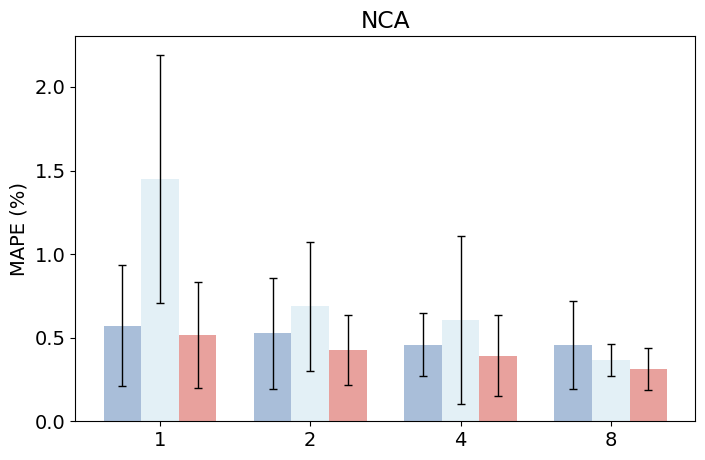

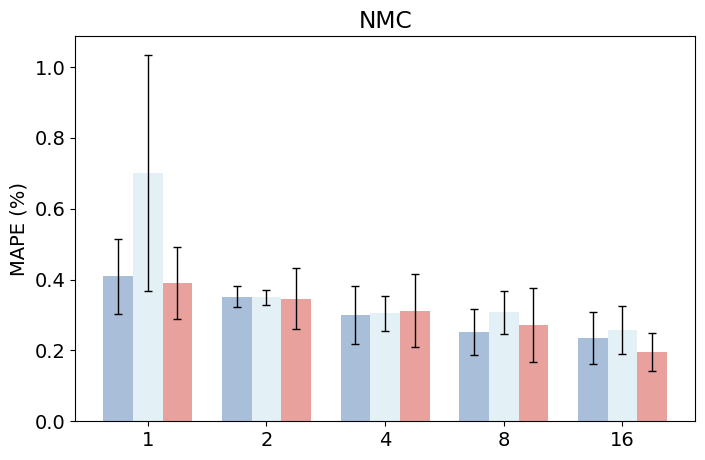

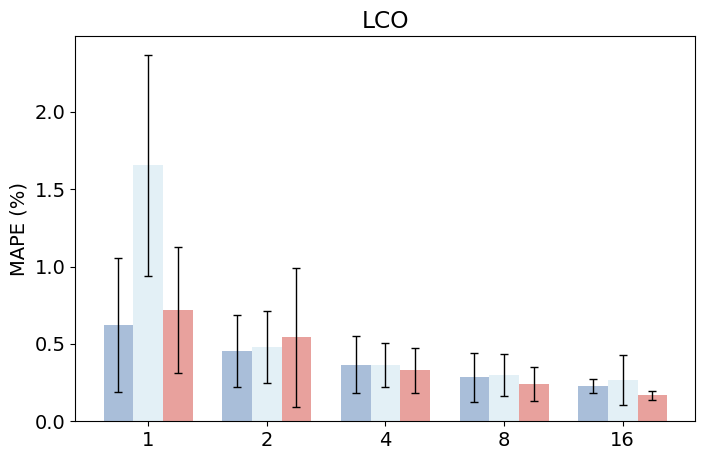

In [15]:
colors = ['#A9BED9', '#E3F0F6', '#E8A19D', '#FEE3C3']
train_count_map = {
    'NCA': [1, 2, 4, 8],
    'NMC': [1, 2, 4, 8, 16],
    'LCO': [1, 2, 4, 8, 16]
}

for material in train_count_map:
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    score_mat = np.random.rand(3, len(train_count_map[material]))
    std_mat = np.random.rand(3, len(train_count_map[material])) / 10

    for indx, train_count in enumerate(train_count_map[material]):
        folder = HOME / f'workspaces/transfer_pos_100epoch/{material}_{train_count}'
        seed_scores = [[], [], []]
        for file in folder.glob('*.pkl'):
            with open(file, 'rb') as f:
                scores = pickle.load(f)
            seed_scores[0].append(mape(scores['intracd_preds'], scores['labels']))
            seed_scores[1].append(mape(scores['finetune_preds'], scores['labels']))
            seed_scores[2].append(mape(
                (scores['intracd_preds'] + scores['intercd_preds']) / 2, scores['labels']
            ))
            # seed_scores[2].append(mape(scores['intercd_preds'], scores['labels']))
        score_mat[0, indx] = np.mean(seed_scores[0])
        std_mat[0, indx] = np.std(seed_scores[0])

        # Finetune
        score_mat[1, indx] = np.mean(seed_scores[1])
        std_mat[1, indx] = np.std(seed_scores[1])

        # BatliNet
        score_mat[2, indx] = np.mean(seed_scores[2])
        std_mat[2, indx] = np.std(seed_scores[2])

    x = np.arange(len(train_count_map[material]))
    width = 1 / (len(score_mat) + 1)
    for indx, method_score in enumerate(score_mat):
        ax.bar(
            x + indx * width,
            method_score,
            yerr=std_mat[indx],
            width=width,
            color=colors[indx],
            error_kw=dict(capsize=3, capthick=1, lw=1),
            # error bar color is darker than grey
            ecolor='black'
        )
    ax.set_title(material)
    ax.set_xticks(x + (len(score_mat) - 1) * width / 2, train_count_map[material])
    ax.set_ylabel('MAPE (%)')
    plt.show()